In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from prophet import Prophet
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

/workspaces/Intelligent-Customer-Feedback-Analysis-System-using-AI/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv('dataset/csv/processed_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['sentiment'] = df['original_label']
df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 1: 'Positive'})
negative_feedback = df[df['sentiment'] == 0]['processed_text'].tolist()
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20, stop_words='english')
ngram_matrix = vectorizer.fit_transform(negative_feedback)
ngram_freq = ngram_matrix.sum(axis=0).A1
ngram_names = vectorizer.get_feature_names_out()

In [5]:
issue_df = pd.DataFrame({
    'Issue/Complaint': ngram_names,
    'Frequency': ngram_freq
}).sort_values('Frequency', ascending=False)
issue_categories = {
    'Quality Issues': [],
    'Delivery Problems': [],
    'Customer Service': [],
    'Price Concerns': [],
    'Product Defects': []
}

In [6]:
for issue in issue_df['Issue/Complaint'].head(20):
    if any(word in issue for word in ['quality', 'poor', 'bad', 'defect']):
        issue_categories['Quality Issues'].append(issue)
    elif any(word in issue for word in ['delivery', 'shipping', 'late', 'arrived']):
        issue_categories['Delivery Problems'].append(issue)
    elif any(word in issue for word in ['service', 'support', 'help', 'customer']):
        issue_categories['Customer Service'].append(issue)
    elif any(word in issue for word in ['price', 'expensive', 'cost', 'money']):
        issue_categories['Price Concerns'].append(issue)
    else:
        issue_categories['Product Defects'].append(issue)

In [7]:
for category, issues in issue_categories.items():
    print(f"\n{category}: {len(issues)} issues")
    for issue in issues[:3]:
        print(f"  - {issue}")

issue_df.to_csv('dataset/csv/recurring_issues.csv', index=False)


Quality Issues: 0 issues

Delivery Problems: 0 issues

Customer Service: 0 issues

Price Concerns: 2 issues
  - waste money
  - dont waste money

Product Defects: 18 issues
  - read book
  - book read
  - dont waste


In [9]:
print(df['sentiment'].value_counts())

sentiment
0    764
1    736
Name: count, dtype: int64


In [10]:
df['satisfaction_score'] = df['sentiment'].map({0: 1, 1: 5})
daily_satisfaction = df.groupby(df['timestamp'].dt.date).agg({
    'satisfaction_score': 'mean',
    'feedback_id': 'count'
}).reset_index()
daily_satisfaction.columns = ['date', 'avg_satisfaction', 'feedback_count']
daily_satisfaction['date'] = pd.to_datetime(daily_satisfaction['date'])
print(daily_satisfaction.head())

        date  avg_satisfaction  feedback_count
0 2023-01-01          3.666667              24
1 2023-01-02          2.833333              24
2 2023-01-03          3.000000              24
3 2023-01-04          3.166667              24
4 2023-01-05          3.333333              24


In [11]:
prophet_df = daily_satisfaction[['date', 'avg_satisfaction']].copy()
prophet_df.columns = ['ds', 'y']
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.05
)
model.fit(prophet_df)

18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
future_predictions = forecast[forecast['ds'] > daily_satisfaction['date'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
future_predictions.columns = ['date', 'predicted_satisfaction', 'lower_bound', 'upper_bound']
print(future_predictions.head(10))
current_avg = daily_satisfaction['avg_satisfaction'].tail(7).mean()
predicted_avg = future_predictions['predicted_satisfaction'].mean()
trend = "Improving" if predicted_avg > current_avg else "Declining"
trend_pct = ((predicted_avg - current_avg) / current_avg) * 100
future_predictions.to_csv('dataset/csv/satisfaction_forecast.csv', index=False)

         date  predicted_satisfaction  lower_bound  upper_bound
63 2023-03-05                2.950851     1.995086     3.794723
64 2023-03-06                2.802680     1.956440     3.689270
65 2023-03-07                3.191723     2.349683     4.158833
66 2023-03-08                3.025038     2.149924     3.902114
67 2023-03-09                3.006544     2.034637     3.897320
68 2023-03-10                3.006574     2.166070     3.884955
69 2023-03-11                2.580539     1.681577     3.502153
70 2023-03-12                2.948308     2.111391     3.779987
71 2023-03-13                2.800137     1.898389     3.684046
72 2023-03-14                3.189180     2.370214     4.028750


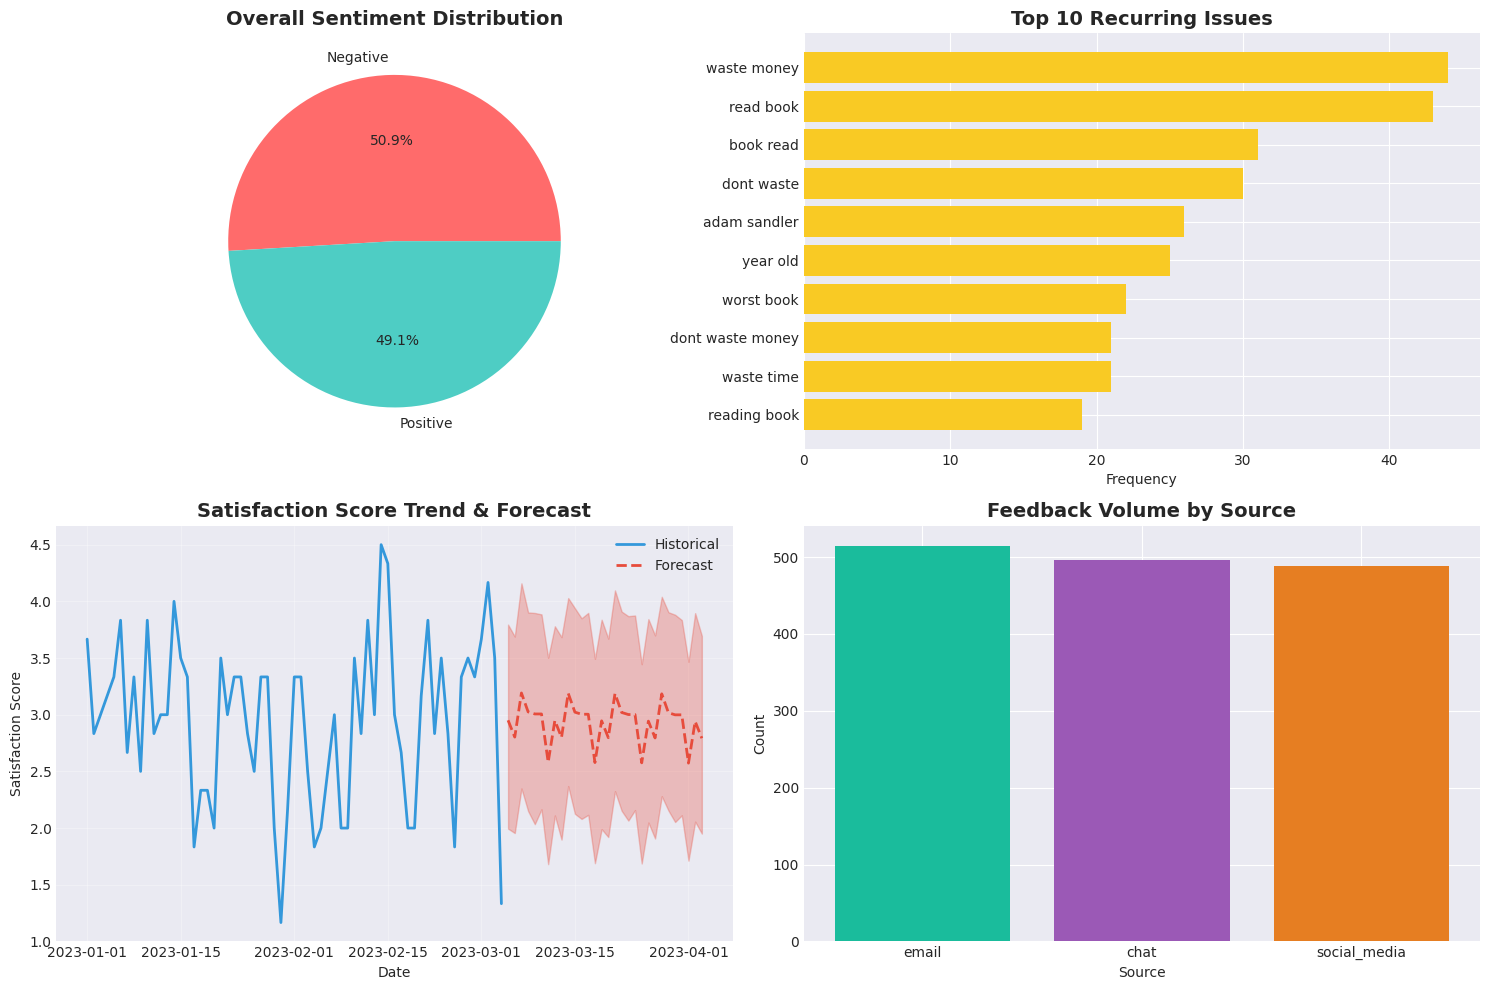

In [15]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sentiment_counts = df['sentiment_label'].value_counts()
axes[0, 0].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0, 0].set_title('Overall Sentiment Distribution', fontsize=14, fontweight='bold')
top_issues = issue_df.head(10)
axes[0, 1].barh(top_issues['Issue/Complaint'], top_issues['Frequency'], color='#f9ca24')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Top 10 Recurring Issues', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[1, 0].plot(daily_satisfaction['date'], daily_satisfaction['avg_satisfaction'], label='Historical', linewidth=2, color='#3498db')
axes[1, 0].plot(future_predictions['date'], future_predictions['predicted_satisfaction'], label='Forecast', linewidth=2, linestyle='--', color='#e74c3c')
axes[1, 0].fill_between(future_predictions['date'], future_predictions['lower_bound'], future_predictions['upper_bound'], alpha=0.3, color='#e74c3c')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Satisfaction Score')
axes[1, 0].set_title('Satisfaction Score Trend & Forecast', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
source_counts = df['source'].value_counts()
axes[1, 1].bar(source_counts.index, source_counts.values, color=['#1abc9c', '#9b59b6', '#e67e22'])
axes[1, 1].set_xlabel('Source')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Feedback Volume by Source', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset/image/insights_visualization.png', dpi=300, bbox_inches='tight')
total_feedback = len(df)
positive_pct = (df['sentiment'] == 1).sum() / total_feedback * 100
negative_pct = (df['sentiment'] == 0).sum() / total_feedback * 100
neutral_pct = (df['sentiment'] == 2).sum() / total_feedback * 100

In [16]:
insights = {
    'overview': {
        'total_feedback': total_feedback,
        'date_range': f"{df['timestamp'].min().date()} to {df['timestamp'].max().date()}",
        'positive_sentiment': f"{positive_pct:.1f}%",
        'negative_sentiment': f"{negative_pct:.1f}%",
        'neutral_sentiment': f"{neutral_pct:.1f}%"
    },
    'recurring_issues': {
        'total_unique_issues': len(issue_df),
        'most_common_issue': issue_df.iloc[0]['Issue/Complaint'],
        'issue_frequency': int(issue_df.iloc[0]['Frequency']),
        'categories': {k: len(v) for k, v in issue_categories.items()}
    },
    'satisfaction_trends': {
        'current_avg_score': f"{current_avg:.2f}",
        'predicted_avg_score': f"{predicted_avg:.2f}",
        'trend': trend,
        'change_percentage': f"{trend_pct:+.2f}%"
    },
    'recommendations': [
        f"Address top issue: '{issue_df.iloc[0]['Issue/Complaint']}' (mentioned {int(issue_df.iloc[0]['Frequency'])} times)",
        "Focus on improving Quality Issues category with most complaints",
        f"Monitor {trend.lower()} satisfaction trend closely",
        "Implement proactive customer service for negative feedback sources"
    ]
}

In [17]:
report_content = f"""
CUSTOMER FEEDBACK ANALYSIS - INSIGHTS REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*60}

1. EXECUTIVE SUMMARY
{'='*60}
Total Feedback Analyzed: {insights['overview']['total_feedback']:,}
Analysis Period: {insights['overview']['date_range']}

Sentiment Distribution:
  • Positive: {insights['overview']['positive_sentiment']}
  • Negative: {insights['overview']['negative_sentiment']}
  • Neutral: {insights['overview']['neutral_sentiment']}

2. RECURRING ISSUES & COMPLAINTS
{'='*60}
Total Unique Issues Identified: {insights['recurring_issues']['total_unique_issues']}

Most Common Issue: "{insights['recurring_issues']['most_common_issue']}"
Frequency: {insights['recurring_issues']['issue_frequency']} mentions

Issues by Category:
"""

for category, count in insights['recurring_issues']['categories'].items():
    report_content += f"  • {category}: {count} issues\n"

report_content += f"""
Top 5 Critical Issues:
"""
for idx, row in issue_df.head(5).iterrows():
    report_content += f"  {idx+1}. {row['Issue/Complaint']} (Frequency: {int(row['Frequency'])})\n"

report_content += f"""
3. CUSTOMER SATISFACTION TRENDS
{'='*60}
Current 7-Day Average: {insights['satisfaction_trends']['current_avg_score']}/5.0
Predicted 30-Day Average: {insights['satisfaction_trends']['predicted_avg_score']}/5.0
Trend: {insights['satisfaction_trends']['trend']} ({insights['satisfaction_trends']['change_percentage']})

Forecast Summary:
"""

for idx, row in future_predictions.head(7).iterrows():
    report_content += f"  {row['date'].strftime('%Y-%m-%d')}: {row['predicted_satisfaction']:.2f} (Range: {row['lower_bound']:.2f} - {row['upper_bound']:.2f})\n"

report_content += f"""
4. KEY INSIGHTS & RECOMMENDATIONS
{'='*60}
"""
for idx, rec in enumerate(insights['recommendations'], 1):
    report_content += f"{idx}. {rec}\n"

report_content += f"""
5. DATA SOURCES & METHODOLOGY
{'='*60}
Feedback Sources:
"""
for source, count in df['source'].value_counts().items():
    report_content += f"  • {source.title()}: {count} feedbacks\n"

report_content += f"""
Models Used:
  • Sentiment Analysis: DistilBERT (Transformer-based)
  • Forecasting: Facebook Prophet (Time Series)
  • Issue Detection: TF-IDF + N-gram Analysis

6. NEXT STEPS
{'='*60}
1. Immediate Action: Address top 3 recurring issues
2. Monitor satisfaction trends weekly
3. Implement feedback loop improvements
4. Schedule follow-up analysis in 30 days

{'='*60}
END OF REPORT
"""

In [18]:
with open('dataset/text/AI_insights_report.txt', 'w') as f:
    f.write(report_content)

import json
with open('dataset/json/insights_data.json', 'w') as f:
    json.dump(insights, f, indent=2)